<a href="https://colab.research.google.com/github/jadeyee/hrbrthemes/blob/master/Musicality_of_proseipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install syllables
!pip install pronouncing

     |████████████████████████████████| 942kB 4.5MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6224 sha256=857ec5aad0ace7e755419c38eb87a49e05e718b8090c8d8cdec03dad04fc5348
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing


In [0]:
import syllables
import seaborn
import pandas as pd
import pronouncing
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from google.colab import files


class TextFragments:
  ''' 
  This turns a block of text into a dataframe. The idea is to save things
  like sentence phrasing. This also makes it possible to do 'dumb' feature
  extraction.  
  ''' 
  # Initializer / Instance Attributes
  def __init__(self):
      self.text = None
      self.data = None

  def __split(self,st, seps, defsep="***"):
    for s in seps: 
      st = st.replace(s, defsep)
    return st.split(defsep)

  def __merge_two_dicts(self,x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

  
  def fragment(self,text):

    speechSections = text.replace('’',"'").split('\n\n')
    speechSectionsLists = []
    data = {}
    splitPunctuation = ['.',';',',','!','?','\n', '-','–',':']
    import re
    pattern = re.compile("".join(splitPunctuation))
    sectionNumber = 0
    data = []
    for section in speechSections:
      speechSectionLists=[]
      sentences = section.split('.')
      sentenceNumber = 0
      for sentence in sentences:
        punctuation = pattern.findall(sentence)
        phrases = self.__split(sentence, splitPunctuation)
        phraseNumber = 0
        for phrase in phrases: 
          if phrase == '':
            continue
          words = phrase.strip().split(' ')
          wordNumber=0
          for word in words:
            wordBlob = {  # Probably better to make relational 
                'text': word,
                'wordNumber': wordNumber,
                'phraseNumber': phraseNumber,
                'sentenceNumber': sentenceNumber,
                'sectionNumber':sectionNumber}
            data.append(wordBlob)
            wordNumber += 1
          phraseNumber += 1
        sentenceNumber += 1
      sectionNumber += 1
    self.text = text
    self.data = data

  def aggregate(self, 
                columns = ['syllables', 'words'], 
                grain = ['sectionNumber','sentenceNumber','phraseNumber'], 
                concatColumns = ['text']):
    grainLevelTmp = pd.DataFrame(self.data)
    grainLevel = grainLevelTmp.groupby(grain).sum()[columns]
    for concatColumn in concatColumns: 
      grainLevelTmp[concatColumn] = grainLevelTmp.groupby(grain)[concatColumn].transform(lambda x: ' '.join(x))
      grainLevel[concatColumn] = grainLevelTmp.groupby(grain)[concatColumn].max()
    return grainLevel
    

<5x145 sparse matrix of type '<class 'numpy.float64'>'
	with 157 stored elements in Compressed Sparse Row format>

In [0]:
######## FEATURE EXTRACTION... Add this to text fragments. 
def quantify(word):
  # TO DO: Confirm that it is a word 
  s = syllables.estimate(word)
  phones_list = pronouncing.phones_for_word(word) # TO DO: Remove ("' and other punctuation
  if len(phones_list) > 0: 
    phones = phones_list[0]
    stresses = pronouncing.stresses(phones_list[0])
  else: 
    phones = 'MISSING'
    stresses = '9'
    print("The word " + str(word) + " is not in the CMU library")
  quantification = {
      'syllables':s,
      'phones':phones,
      'stresses':stresses,
      'words':len(word.strip().split( ))
  }
  if s==None:
    return quantification.fromkeys(quantification.iterkeys(), 0)
  return quantification

# Consider phrase or sentence-level patterns, e.g. repetition of specific words or sounds. 
######## </FEATURE EXTRACTION>

def download(finalFile, fname):
  finalFile.to_csv(fname)
  files.download(fname)


def extractFeatures(s):
  ''' 
  Temporary way to extract features.
  '''
  pipe = make_pipeline(
      TfidfVectorizer()#analyzer='char')
      )
  d=pd.DataFrame(s.data)
  tdifphones = pipe.fit_transform(d.text)
  tfidnames=[a.strip().upper() for a in pipe[0].get_feature_names()]
  tfidAsDf = pd.DataFrame.sparse.from_spmatrix(tdifphones, columns=tfidnames)
  tmp1 = pd.DataFrame([quantify(t) for t in d.text.values])
  finalFile = tmp1.merge(tfidAsDf, left_index=True, right_index=True).merge(d, left_index=True, right_index=True)
  return finalFile

In [0]:
import requests as r

speechUrls=["https://raw.githubusercontent.com/jadeyee/speeches/master/mlk_dream", 
            "https://raw.githubusercontent.com/jadeyee/speeches/master/faulker_nobel",
            "https://raw.githubusercontent.com/jadeyee/speeches/master/niels_bohr_physics",
            "https://raw.githubusercontent.com/jadeyee/speeches/master/gabriela_mistral_poetry",
            "https://raw.githubusercontent.com/jadeyee/speeches/master/Ernest_Hemingway_literature",
            "https://raw.githubusercontent.com/jadeyee/speeches/master/elie_wiesel_peace"]

speechFiles = {}

for speechUrl in speechUrls: 
  text = r.get(speechUrl).text
  s = TextFragments()
  s.fragment(text)
  finalFile = extractFeatures(s)
  speechFiles[str(speechUrl.split('/')[-1])] = finalFile


#fname = str(speechUrl.split('/')[-1]) + ".csv"
#download(finalFile)



The word manacles is not in the CMU library
The word 'We is not in the CMU library
The word " is not in the CMU library
The word interposition is not in the CMU library
The word discords is not in the CMU library
The word )mowing is not in the CMU library
The word curvaceous is not in the CMU library
The word "Free is not in the CMU library
The word " is not in the CMU library
The word basest is not in the CMU library
The word griefs is not in the CMU library
The word relearns is not in the CMU library
The word dingdong is not in the CMU library
The word clanged is not in the CMU library
The word tideless is not in the CMU library
The word Highnesses is not in the CMU library
The word Nobel's is not in the CMU library
The word munificent is not in the CMU library
The word elucidating is not in the CMU library
The word fruitfulness is not in the CMU library
The word availing is not in the CMU library
The word manifoldly is not in the CMU library
The word Gajardo is not in the CMU librar

In [0]:
# grain = ['sectionNumber']
# #grain = ['sectionNumber','sentenceNumber','phraseNumber']
# functionColumns = []
# concatColumns = ['text']

# df = s.aggregate(functionColumns, grain, concatColumns)

[array([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 4, 1, 2, 1,
        1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 2, 3, 2, 1, 1, 2, 2, 1, 4,
        4, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1,
        1, 2, 1, 3, 4, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 2,
        1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
        1, 3, 1, 4, 1, 1, 1, 1, 5, 1, 2, 1, 2, 1, 2, 2, 1, 1, 3, 2, 1, 3,
        1, 1, 1, 1, 1, 1, 2, 1, 3, 4, 1, 2, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2,
        1, 3, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2,
        3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 4, 1,
        1, 2, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 2, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 4, 1, 3, 2,
        1, 2, 1, 2, 4, 1, 1, 1, 3, 2, 1, 2, 1, 1, 1, 2, 1, 3, 1, 4, 1, 1,
        1, 2, 1, 3, 2, 1, 5, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2,
        3, 2, 1, 1, 2, 1, 1, 3, 1, 4, 

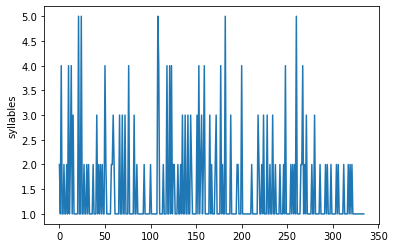

In [0]:
import seaborn 

# Looking at syllables by word (in order)
seaborn.lineplot(x=range(0,len(finalFile)),y=finalFile['syllables'])

In [0]:
functionColumns = ['syllables', 'words']
concatColumns = ['phones','stresses', 'text']
aggdf = aggLevel(df, functionColumns, grain, concatColumns)



listOfStresses = [item for sublist in aggdf['stresses'].tolist() for item in sublist]
listOfStresses = [int(value) for value in listOfStresses if value != ' ']

phones
stresses
text
